In [2]:
# Packages for data cleaning and visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

# Packages to work with coordinates and calculate distances between areas
import geopandas as gpd
from shapely.geometry import Point
from geopy.geocoders import Nominatim
import contextily as cx
from collections import Counter
import matplotlib.font_manager
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Packages for machine learning
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score 

from yellowbrick.regressor import PredictionError, ResidualsPlot
from sklearn.linear_model import Ridge

In [3]:
#loading the cleaned house data into the main dataframe
df = pd.read_csv('NigeriaCleanedAreaDummy2.csv')

In [4]:
# Values in the Nigerian currency (Naira) are so large (1 CHF ~ 400 Naira) -> apply logarithm
df['Price_log'] = df['Price'].apply(np.log)

In [5]:
# Create a new dataframe in order to assign each area a unique index
Area_df = pd.DataFrame(df.groupby(df.Area_dummy_1)['Price'].mean())
Area_df['Location'] = df.Area.unique()
Area_df = Area_df.sort_values(by='Price').reset_index()



In [6]:
list_of_areas = np.arange(1,37)


Area_number = {}
for i,x in zip(df.Area.unique(),list_of_areas ):
    Area_number[i] = x
    
Area_dummy = []
for i in range(len(df['Area'])):
    Area_dummy.append(Area_number[df['Area'].values[i]])
    
df['Area_dummy_1'] = pd.DataFrame(Area_dummy)

In [7]:
# The difference between this code and the code above is that here we use the new area dataframe "Area_df" 
# to assign each area an index
# We do this to ensure that we enumerate the area in ascending order according to the mean of prices in each area
# that means the area in which the average house prices are the lowest get the index "0"

list_of_areas = np.arange(1,37)


Area_number = {}
for i,x in zip(Area_df.Location,list_of_areas):
    Area_number[i] = x
    
Area_dummy = []
for i in range(len(df['Area'])):
    Area_dummy.append(Area_number[df['Area'].values[i]])
    

df['Area_dummy_2'] = pd.DataFrame(Area_dummy)

In [10]:
latest_geo = pd.read_csv('NigeriaCleanedFinalCoordinates.csv')

In [11]:
df["location_append"] = df["Area"] + ", " + df["State"]

In [12]:
geolocator = Nominatim(user_agent="myApp")

long = {}
lat = {}

for i in df["location_append"].unique():
        
        location = geolocator.geocode([i])
        
        long[i] = location.longitude
        lat[i] = location.latitude


In [13]:
loncol = []
latcol = []

for i in df["location_append"]:
        loncol.append(long[i])
        latcol.append(lat[i])

#loncoladj = [i * 100000 for i in loncol]
#latcoladj = [i * 100000 for i in latcol]

df["Longitude"] = loncol
df["Latitude"] = latcol

In [14]:
df_geo = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df["Longitude"], df["Latitude"]), crs="epsg:4326")


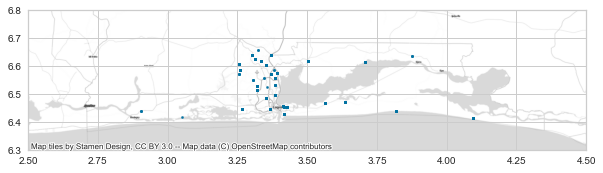

In [15]:
fig, ax = plt.subplots(figsize = (10,100))

ax.set_aspect("equal")
ax.set_xlim(2.5,4.5)
ax.set_ylim(6.3,6.8)

#Lagos.plot(ax=ax, alpha=0.4, edgecolor='k')
df_geo.plot(ax=ax, markersize= 5,)

cx.add_basemap(ax, source=cx.providers.Stamen.TonerLite, crs=df_geo.crs.to_string())

In [17]:
# from https://en.wikipedia.org/wiki/Lagos
# coordinates: 6.455027°N 3.384082°E

pnt1 = Point(3.384082, 6.455027)
distances_from_center = []

for i in df.geometry:

    points_df = gpd.GeoDataFrame({'geometry': [pnt1, i]}, crs='EPSG:4326')
 
    points_df2 = points_df.shift() #We shift the dataframe by 1 to align pnt1 with pnt2
    distances_from_center.append(points_df.distance(points_df2))
    

C:\Users\laure\AppData\Roaming\Python\Python39\site-packages\geopandas\array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(
C:\Users\laure\AppData\Local\Temp\ipykernel_22400\3657969812.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  distances_from_center.append(points_df.distance(points_df2))
C:\Users\laure\AppData\Roaming\Python\Python39\site-packages\geopandas\array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(
C:\Users\laure\AppData\Local\Temp\ipykernel_22400\3657969812.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a pro

In [18]:
df_num = df[['Price', 'Serviced', 'Newly Built', 'Furnished',
       'Bedrooms', 'Bathrooms', 'Toilets', 'Duplex', 'Terraced', 'Detached', 'Apartment',  
       'Price_log','geometry', 'distances_of_area_from_center', 'Area_dummy_2']]

# this new dataframe has only values which are numbers, we drop those columns which have string datatypes

In [21]:
# Clean Prices
df_price = pd.read_csv('nigeria-rent.csv')

df_price['Price'].replace(',', '', regex=True, inplace=True)
df_price['Price'] = df_price.Price.str.extract('(^\d*)') # Doesn't seem like it's needed, maybe add back later
df_price['Price'] = pd.to_numeric(df_price['Price'])

Text(0, 0.5, 'Number of Houses\n')

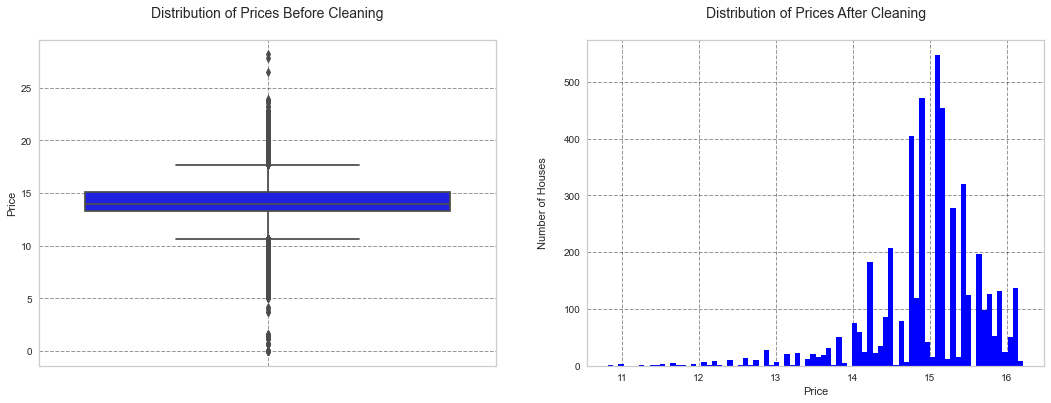

In [24]:
# We use here the old dataframe which has not been cleaned to show the distribution of prices before and 
# after cleaning the data

fig, axs = plt.subplots(1, 2, figsize=(18, 6))

sns.boxplot(y=df_price['Price'].apply(np.log), ax=axs[0], color='blue')

axs[1].hist(df.loc[df.Price_log>10].Price_log, bins=80, color='blue')

sns.set(style="darkgrid")
axs[0].grid(color="black", which = "major", linestyle = "--", linewidth = 1, alpha = 0.4)
axs[1].grid(color="black", which = "major", linestyle = "--", linewidth = 1, alpha = 0.4)

axs[0].set_title('Distribution of Prices Before Cleaning\n', size=14)
axs[1].set_title('Distribution of Prices After Cleaning\n', size=14)

axs[1].set_xlabel("Price")
axs[1].set_ylabel("Number of Houses\n")

C:\Users\laure\AppData\Local\Temp\ipykernel_22400\4206901206.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_yticklabels(ylabels)


TypeError: 'AxesSubplot' object is not subscriptable

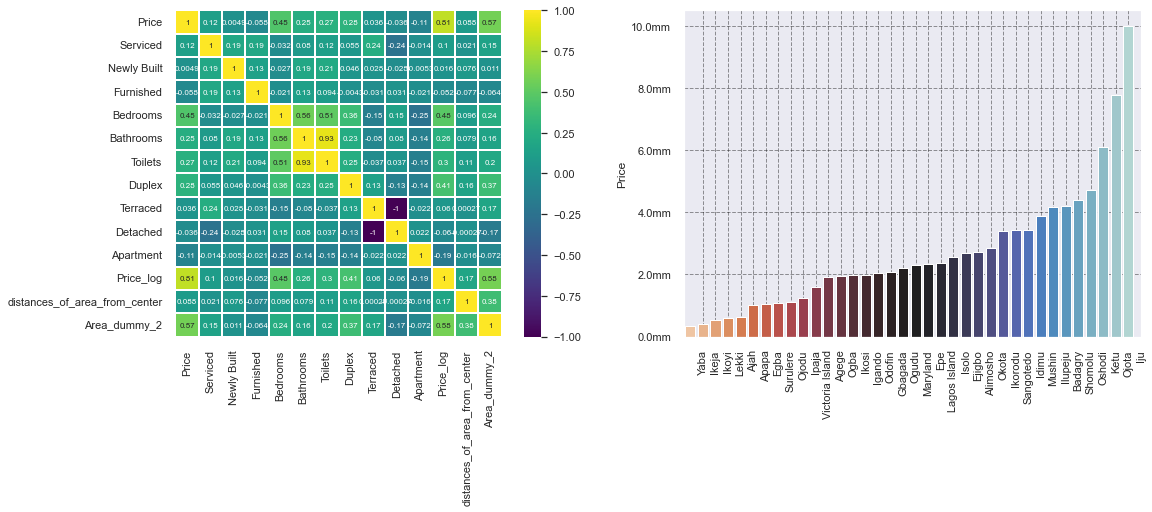

In [25]:
# the correlation matrix, respectively the heatmap gives us an overview of the links between different 
# features and the price (we use the logarithmed price and the price before transformation)


fig, axs = plt.subplots(1, 2, figsize=(18, 6))

corr = df_num.corr()


sns.heatmap(corr, 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True, ax=axs[0])

sns.barplot(data=df, x=df.Area_dummy_1.unique(), 
                  y=df.groupby(df.Area_dummy_1)['Price'].mean().sort_values(), ci=False, ax=axs[1], palette='icefire_r')
xticks = [i for i in range(1,37)]
area_list = []
for y in df.Area.unique():
    area_list.append(y)
    

xticklabels = area_list
plt.xticks(xticks, xticklabels, rotation=90)

sns.set(style="darkgrid")
axs[1].grid(color="black", which = "major", linestyle = "--", linewidth = 1, alpha = 0.4)


ylabels = ['{:,.1f}'.format(y) + 'mm' for y in axs[1].get_yticks()/1000000]
axs[1].set_yticklabels(ylabels)

ax[1].set_xlabel('\n\n\n\n\n\nd')

In [27]:
df_reg = df[['Price_log', 'Price', 'distances_of_area_from_center']]
X, y = df_reg[["distances_of_area_from_center"]], df_reg["Price"] 
# Define the estimator
ols1 = LinearRegression() 

In [28]:
# Fit the estimator 
ols1.fit(X, y)
# Add the predictions to our `crops` dataframe
df_reg["pred"] = ols1.predict(X)

# Get value of constant and coefficient
print(f"constant: {ols1.intercept_:.2f}, coefficient: {ols1.coef_[0]:.2f}.")

constant: 3551330.11, coefficient: 6668.63.


C:\Users\laure\AppData\Local\Temp\ipykernel_22400\3704303657.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reg["pred"] = ols1.predict(X)


In [29]:
# 2 degrees of polynomials, without the constant
poly2 = PolynomialFeatures(2, include_bias=False) 
# Define a new X with the squared feature
X2 = poly2.fit_transform(X)


In [30]:
# Define a new OLS object
ols2 = LinearRegression()

In [31]:
# Fit the estimator 
ols2.fit(X2, y)
# Add the predictions to our `crops` dataframe
df_reg["pred2"] = ols2.predict(X2)

C:\Users\laure\AppData\Local\Temp\ipykernel_22400\1978297381.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reg["pred2"] = ols2.predict(X2)


C:\Users\laure\AppData\Local\Temp\ipykernel_22400\4256401544.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabels)
C:\Users\laure\AppData\Local\Temp\ipykernel_22400\4256401544.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ylabels)


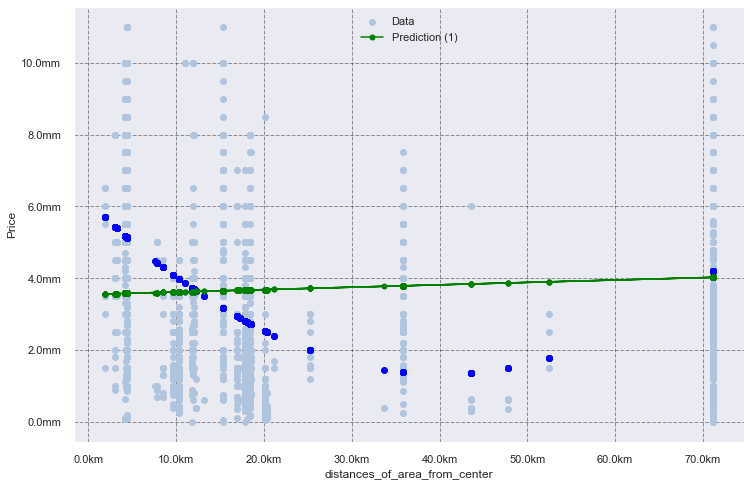

In [32]:
# Visualize our predictions
# Set up the canvas
fig, ax = plt.subplots(figsize=(12, 8))
# Add scatterplot
ax.scatter(df_reg["distances_of_area_from_center"], df_reg["Price"], label="Data", color='lightsteelblue')
ax.plot(df_reg["distances_of_area_from_center"], df_reg["pred"], "-o", label="Prediction (1)", color="green")
ax.scatter(df_reg["distances_of_area_from_center"], df_reg["pred2"], color="blue")#, "-o", label="Prediction (2))"
# Label axes
ax.set_xlabel("distances_of_area_from_center")
ax.set_ylabel("Price")
# Add a grid
ax.grid(True)
# Add a legend
ax.legend()

sns.set(style="darkgrid")
plt.grid(color="black", which = "major", linestyle = "--", linewidth = 1, alpha = 0.4)

xlabels = ['{:,.1f}'.format(x) + 'km' for x in ax.get_xticks()]
ax.set_xticklabels(xlabels)

ylabels = ['{:,.1f}'.format(y) + 'mm' for y in ax.get_yticks()/1000000]
ax.set_yticklabels(ylabels)

fig.savefig('with_lekki')

In [33]:
ols1_score = ols1.score(X, y)
ols2_score = ols2.score(X2, y)

In [34]:
print(f'for the first regression ols1 we have a R2 score of {ols1_score}\n'
     f'for the second regression ols2 we have a R2 score of {ols2_score}')

for the first regression ols1 we have a R2 score of 0.007779240057191994
for the second regression ols2 we have a R2 score of 0.15945291252485905


In [35]:
df_no_lekki = df.loc[df['Area']!='Lekki']

In [36]:
X_lekki, y_lekki = df_no_lekki[["distances_of_area_from_center"]], df_no_lekki["Price"] 
# Define the estimator
no_lekki_reg = LinearRegression() 

In [37]:
# Fit the estimator 
no_lekki_reg.fit(X_lekki, y_lekki)
# Add the predictions to our `crops` dataframe
df_no_lekki["pred"] = no_lekki_reg.predict(X_lekki)

# Get value of constant and coefficient
print(f"constant: {ols1.intercept_:.2f}, coefficient: {ols1.coef_[0]:.2f}.")

constant: 3551330.11, coefficient: 6668.63.


C:\Users\laure\AppData\Local\Temp\ipykernel_22400\942829483.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_lekki["pred"] = no_lekki_reg.predict(X_lekki)


In [38]:
# 2 degrees of polynomials, without the constant
poly2 = PolynomialFeatures(2, include_bias=False) 
# Define a new X with the squared feature
X_lekki2 = poly2.fit_transform(X_lekki)
X_lekki2[:5, :] # Check the first five rows of our new features

array([[  4.28806659,  18.38751506],
       [ 15.29807324, 234.03104499],
       [  4.4052135 ,  19.40590601],
       [ 17.88882292, 320.00998546],
       [  1.85362619,   3.43593005]])

In [39]:
# Define a new OLS object
no_lekki_reg2 = LinearRegression()

In [40]:
# Fit the estimator 
no_lekki_reg2.fit(X_lekki2, y_lekki)
# Add the predictions to our `crops` dataframe
df_no_lekki["pred2"] = no_lekki_reg2.predict(X_lekki2)

C:\Users\laure\AppData\Local\Temp\ipykernel_22400\1918358587.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_lekki["pred2"] = no_lekki_reg2.predict(X_lekki2)


C:\Users\laure\AppData\Local\Temp\ipykernel_22400\2867023031.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabels)
C:\Users\laure\AppData\Local\Temp\ipykernel_22400\2867023031.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ylabels)


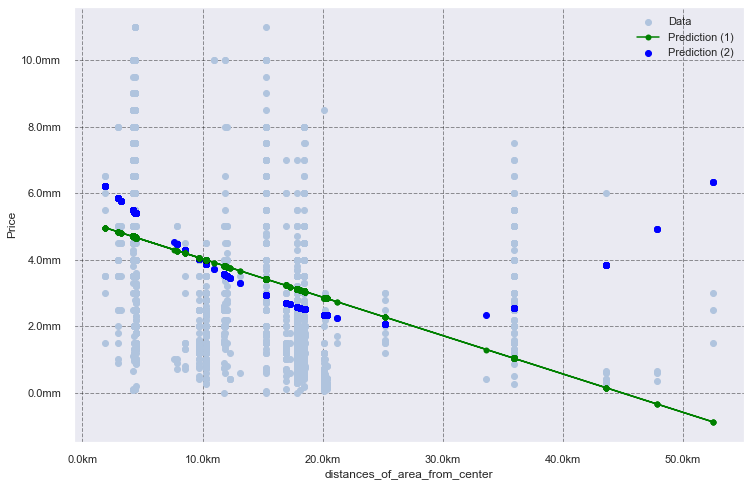

In [41]:
# Visualize our predictions
# Set up the canvas
fig, ax = plt.subplots(figsize=(12, 8))
# Add scatterplot
ax.scatter(df_no_lekki["distances_of_area_from_center"], df_no_lekki["Price"], label="Data", color='lightsteelblue')
ax.plot(df_no_lekki["distances_of_area_from_center"], df_no_lekki["pred"], "-o", label="Prediction (1)", color="green")
ax.scatter(df_no_lekki["distances_of_area_from_center"], df_no_lekki["pred2"], label="Prediction (2)", color="blue")#, "-o", label="Prediction (2)")
# Label axes
ax.set_xlabel("distances_of_area_from_center")
ax.set_ylabel("Price")
# Add a grid
ax.grid(True)
# Add a legend
ax.legend()

sns.set(style="darkgrid")
plt.grid(color="black", which = "major", linestyle = "--", linewidth = 1, alpha = 0.4)


xlabels = ['{:,.1f}'.format(x) + 'km' for x in ax.get_xticks()]
ax.set_xticklabels(xlabels)

ylabels = ['{:,.1f}'.format(y) + 'mm' for y in ax.get_yticks()/1000000]
ax.set_yticklabels(ylabels)


fig.savefig('without_lekki')

In [42]:
lekki_score2 = no_lekki_reg2.score(X_lekki2, y_lekki)
lekki_score = no_lekki_reg.score(X_lekki, y_lekki)


# Compute the MAE of our new model
lekki_score_mae = np.mean(np.abs(df_no_lekki["pred"] - df_no_lekki["Price"]))
lekki_score_mae2 = np.mean(np.abs(df_no_lekki["pred2"] - df_no_lekki["Price"]))
mean_of_price = df_no_lekki["Price"].mean()

In [43]:
print(f'for the first regression without the city lekki we have a R2 score of {lekki_score:.2f}\n'
     f'for the second regression without the city lekki we have a R2 score of {lekki_score2:.2f}\n'
     f'for the first regression without the city lekki we have a mae of {lekki_score_mae:.2f}\n'
     f'for the second regression without the city lekki we have a mea of {lekki_score_mae2:.2f}\n\n'
     f'-> In comparison, the price column has a mean of {mean_of_price:.2f}')

for the first regression without the city lekki we have a R2 score of 0.14
for the second regression without the city lekki we have a R2 score of 0.24
for the first regression without the city lekki we have a mae of 1845249.04
for the second regression without the city lekki we have a mea of 1684401.93

-> In comparison, the price column has a mean of 3504652.62


In [44]:
standardize = lambda x: (x - x.mean()) / x.std()

In [45]:
# Split the dataset into train and test sets
Xtrain, Xtest, ytrain, ytest = train_test_split(
    X_lekki, y_lekki, test_size=0.3, random_state=72)

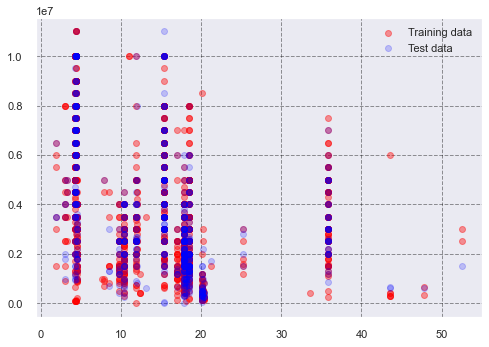

In [46]:
# visualize how the training and test data are distributed
plt.scatter(Xtrain, ytrain, color='red', alpha=0.4, label='Training data')
plt.scatter(Xtest, ytest, color='blue', alpha=0.2, label='Test data')
plt.legend()
sns.set(style="darkgrid")
plt.grid(color="black", which = "major", linestyle = "--", linewidth = 1, alpha = 0.4)

In [47]:
# Define a new Xtrain and Xtest with the squared feature
X2train = poly2.fit_transform(Xtrain)
X2test = poly2.fit_transform(Xtest)

In [48]:
# Define a new Xtrain and Xtest with the higher-order polynomial features
# NOTE: poly3 is the polynomial from your solution to Question 1 above.

Xtrain_s = standardize(Xtrain)



Xtest_s = standardize(Xtest)




In [49]:
# Define the estimator
ols1_t = LinearRegression() 

ols1_t.fit(Xtrain, ytrain)

LinearRegression()

In [50]:
# Define the estimator
ols2_t = LinearRegression() 

ols2_t.fit(X2train, ytrain)

LinearRegression()

In [51]:
# Define some lists to help us compute the metrics
model_list = [ols1_t, ols2_t]
Xtrain_list = [Xtrain, X2train]
ytrain_list = [ytrain for _ in range(2)]
Xtest_list = [Xtest, X2test]
ytest_list = [ytest for _ in range(2)]



In [52]:
# Helpers to compute MSE, MAE, R2
compute_mse = lambda m, X, y: np.mean((m.predict(X) - y) ** 2)
compute_mae = lambda m, X, y: np.mean(np.abs(m.predict(X) - y))
compute_r2  = lambda m, X, y: m.score(X, y)

In [53]:
# Compute the metrics into lists for plotting
# OLS with single feature
ols1_results = {
    "train": [f(ols1_t, Xtrain, ytrain) for f in [compute_mse, compute_mae, compute_r2]],
    "test": [f(ols1_t, Xtest, ytest) for f in [compute_mse, compute_mae, compute_r2]]
}
# OLS with 2 features
ols2_results = {
    "train": [f(ols2_t, X2train, ytrain) for f in [compute_mse, compute_mae, compute_r2]],
    "test": [f(ols2_t, X2test, ytest) for f in [compute_mse, compute_mae, compute_r2]]
}

print("ols1: ", ols1_results)
print("\nols2: ", ols2_results)


ols1:  {'train': [5314330579591.927, 1848589.3880169897, 0.13908265658320362], 'test': [5273763492370.459, 1858584.052083884, 0.15017161684234215]}

ols2:  {'train': [4753431612245.34, 1699188.890211317, 0.22994784490017373], 'test': [4672634491092.181, 1671413.2380188934, 0.2470391551694866]}


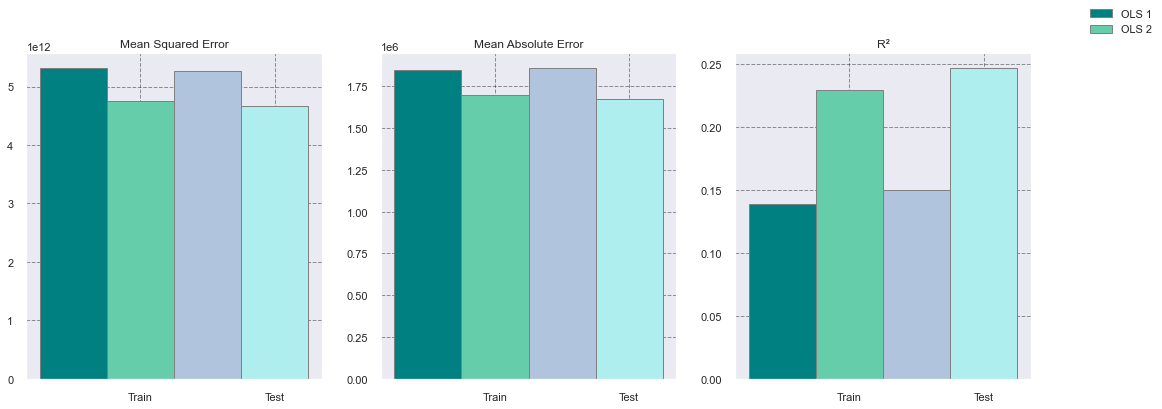

In [54]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
width = .5 # Bar width
for i in range(3):
    labs = [f"OLS {i}" for i in range(1, 4)] if i == 0 else ["" for _ in range(1, 4)]
    axs[i].bar(0, ols1_results["train"][i], width, label=labs[0], color="teal", edgecolor='grey')
    axs[i].bar(0 + width, ols2_results["train"][i], width, label=labs[1], color="mediumaquamarine", edgecolor='grey')
    
    axs[i].bar(1, ols1_results["test"][i], width, color="lightsteelblue", edgecolor='grey')
    axs[i].bar(1 + width, ols2_results["test"][i], width, color="paleturquoise", edgecolor='grey')
    
# Plot titles
axs[0].set_title("Mean Squared Error")
axs[1].set_title("Mean Absolute Error")
axs[2].set_title("R²")
# Labels and legend
for ax in axs:
    ax.set_xticks([width, width + 1], ["Train", "Test"])
fig.legend()

sns.set(style="darkgrid")
axs[0].grid(color="black", which = "major", linestyle = "--", linewidth = 1, alpha = 0.4)
axs[1].grid(color="black", which = "major", linestyle = "--", linewidth = 1, alpha = 0.4)
axs[2].grid(color="black", which = "major", linestyle = "--", linewidth = 1, alpha = 0.4)



In [55]:
mae_cv = -cross_val_score(ols1_t, Xtrain, ytrain, cv=7, scoring="neg_mean_absolute_error")
print(f"Cross-validation mean absolute error: {np.mean(mae_cv):.2f} (± {np.std(mae_cv)/np.sqrt(7):.2f})") 

Cross-validation mean absolute error: 1851016.34 (± 50283.42)


In [61]:
# Create lists to keep track of the results
# for the training set
mae_mean_list = []
mae_se_list = []

r2_score_list = []
# for the test set
#mae_mean_list_test = []
#mae_se_list_test = []

r2_score_list_test = []
# Instantiate a LinearRegression model
ols_cv = LinearRegression()
# Loop over the polynomials
for p in range(1, 21):
    
    # Compute polynomials
    poly = PolynomialFeatures(p, include_bias=False)
    
    X_cv = poly.fit_transform(Xtrain_s)
    X_cv = np.apply_along_axis(standardize,0, X_cv)
    
    
    X_cv_test = poly.fit_transform(Xtest_s)
    X_cv_test = np.apply_along_axis(standardize,0, X_cv_test)
    

    # Run cross-validation
    mae_cv = -cross_val_score(ols_cv, X_cv, ytrain, cv=5, scoring="neg_mean_absolute_error")
    
    #mae_cv_test = -cross_val_score(ols_cv, X_cv_test, ytest, cv=5, scoring="neg_mean_absolute_error")
    # Store the mean and s.e. of the 5-folds
    mae_mean_list.append(np.mean(mae_cv)) 
    mae_se_list.append(np.std(mae_cv) / np.sqrt(20))
    
    #mae_mean_list_test.append(np.mean(mae_cv_test)) 
    #mae_se_list_test.append(np.std(mae_cv_test) / np.sqrt(20))
    
    r2_score = cross_val_score(ols_cv, X_cv, ytrain, cv=20, scoring="r2")

    r2_score_test = cross_val_score(ols_cv, X_cv_test, ytest, cv=20, scoring="r2")
    
    r2_score_list.append(np.mean(r2_score))
    r2_score_list_test.append(np.mean(r2_score_test))

C:\Users\laure\AppData\Local\Temp\ipykernel_22400\1983749542.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ylabels)


[Text(0, -5.9999999999999995e+23, '-600,000,000,000,000,000.0mm'),
 Text(0, -5e+23, '-500,000,000,000,000,000.0mm'),
 Text(0, -4e+23, '-399,999,999,999,999,936.0mm'),
 Text(0, -2.9999999999999997e+23, '-300,000,000,000,000,000.0mm'),
 Text(0, -2e+23, '-199,999,999,999,999,968.0mm'),
 Text(0, -9.999999999999996e+22, '-99,999,999,999,999,952.0mm'),
 Text(0, 0.0, '0.0mm'),
 Text(0, 9.999999999999996e+22, '99,999,999,999,999,952.0mm')]

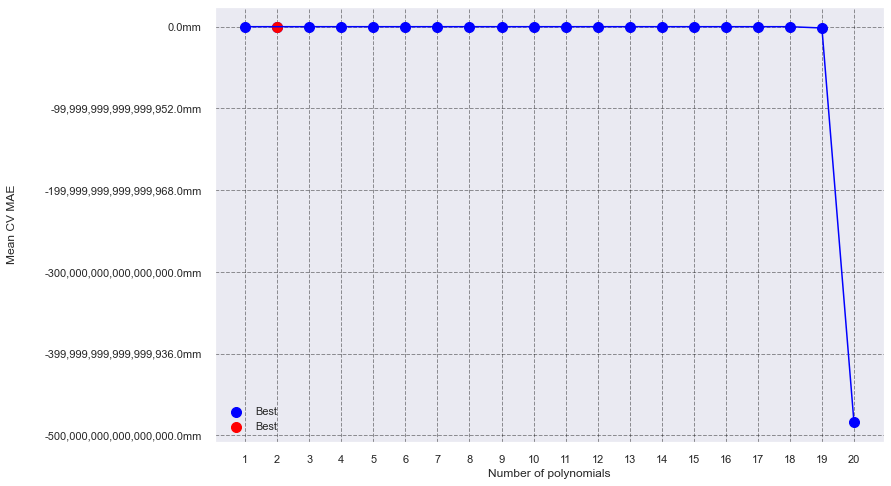

In [62]:
# Plot the results
fig, ax = plt.subplots(figsize=(12, 8))
# Errorbar plot of mean MAE and standard error of the mean MAE
#ax.errorbar(range(1, 21), r2_score_list_test, yerr=r2_score_list_test)
# Single red dot for best result
best = np.argmax(r2_score_list_test)

ax.scatter([i for i in range(1,21)], r2_score_list_test[0:20], color="blue", s=100, label="Best")
ax.plot([i for i in range(1,21)], r2_score_list_test[0:20], color="blue")
ax.scatter(best, r2_score_list_test[best], color="red", s=100, label="Best")
# Add labels, ticks, legend, grid
ax.set_xlabel("Number of polynomials")
ax.set_ylabel("Mean CV MAE\n\n")
ax.legend()
ax.grid(True)
ax.set_xticks(range(1, 21), range(1, 21))

sns.set(style="darkgrid")
ax.grid(color="black", which = "major", linestyle = "--", linewidth = 1, alpha = 0.4)


ylabels = ['{:,.1f}'.format(y) + 'mm' for y in ax.get_yticks()/1000000]
ax.set_yticklabels(ylabels)

C:\Users\laure\AppData\Local\Temp\ipykernel_22400\3320106633.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(ylabels)


[Text(0, 0.0, '0.0mm'),
 Text(0, 2000000.0, '2.0mm'),
 Text(0, 4000000.0, '4.0mm'),
 Text(0, 6000000.0, '6.0mm'),
 Text(0, 8000000.0, '8.0mm'),
 Text(0, 10000000.0, '10.0mm'),
 Text(0, 12000000.0, '12.0mm'),
 Text(0, 14000000.0, '14.0mm')]

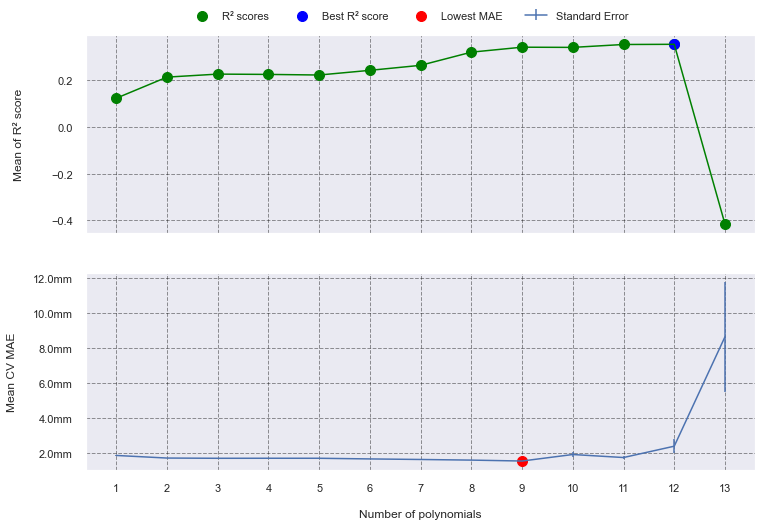

In [63]:
# Again plot the mean CV MAE but this time with a lower number of polynomials, otherwise the 
# graph is not interpretable visually

fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True, sharey=False)

best_r2 = np.argmax(r2_score_list[0:21])

ax[0].scatter([i for i in range(1,14)], r2_score_list[0:13], color="green", s=100, label="R² scores")
ax[0].plot([i for i in range(1,14)], r2_score_list[0:13], color="green")
ax[0].scatter(best_r2+1, r2_score_list[best_r2], color="blue", s=100, label="Best R² score")




ax[0].set_ylabel("Mean of R² score\n\n")

ax[0].set_xticks(range(1,14), range(1,14))

ax[1].errorbar(range(1,14), mae_mean_list[0:13], yerr=mae_se_list[0:13], label='Standard Error')
best = np.argmin(mae_mean_list)
ax[1].scatter(best+1, mae_mean_list[best], color="red", s=100, label="Lowest MAE")

ax[1].set_xlabel("\nNumber of polynomials")
ax[1].set_ylabel("Mean CV MAE\n")

ax[1].grid(True)
ax[1].set_xticks(range(1,14), range(1,14))

fig.legend(ncol=4, loc='upper center', bbox_to_anchor=(0.5, 0.94))

sns.set(style="darkgrid")
ax[0].grid(color="black", which = "major", linestyle = "--", linewidth = 1, alpha = 0.4)
ax[1].grid(color="black", which = "major", linestyle = "--", linewidth = 1, alpha = 0.4)


ylabels = ['{:,.1f}'.format(y) + 'mm' for y in ax[1].get_yticks()/1000000]
ax[1].set_yticklabels(ylabels)

In [64]:
# Define model
ols_best = LinearRegression()
# Compute polynomials
poly_best = PolynomialFeatures(9, include_bias=False)

Xtrain_best = poly_best.fit_transform(Xtrain_s)
Xtrain_best = np.apply_along_axis(standardize,0, Xtrain_best)

Xtest_best = poly_best.fit_transform(Xtest_s)
Xtest_best = np.apply_along_axis(standardize,0, Xtest_best)

# Fit model
ols_best.fit(Xtrain_best, ytrain)
# OLS with 9 features
ols_best_results = {
    "train": [f(ols_best, Xtrain_best, ytrain) for f in [compute_mse, compute_mae, compute_r2]],
    "test": [f(ols_best, Xtest_best, ytest) for f in [compute_mse, compute_mae, compute_r2]]
}

print("ols_best_results: train: ", ols_best_results["train"])
print("\nols_best_results: test: ", ols_best_results["test"])



ols_best_results: train:  [3973577899361.879, 1503353.0551408464, 0.356283528519032]

ols_best_results: test:  [4224904178894.554, 1545675.5428179295, 0.31918761762064674]


In [65]:
# Define model
ols_best2 = LinearRegression()
# Compute polynomials
poly_best2 = PolynomialFeatures(12, include_bias=False)

Xtrain_best2 = poly_best2.fit_transform(Xtrain_s)
Xtrain_best2 = np.apply_along_axis(standardize,0, Xtrain_best2)

Xtest_best2 = poly_best2.fit_transform(Xtest_s)
Xtest_best2 = np.apply_along_axis(standardize,0, Xtest_best2)

# Fit model
ols_best2.fit(Xtrain_best2, ytrain)
# OLS with 9 features
ols_best_results2 = {
    "train": [f(ols_best2, Xtrain_best2, ytrain) for f in [compute_mse, compute_mae, compute_r2]],
    "test": [f(ols_best2, Xtest_best2, ytest) for f in [compute_mse, compute_mae, compute_r2]]
}

print("ols_best_results: train: ", ols_best_results2["train"])
print("\nols_best_results: test: ", ols_best_results2["test"])




ols_best_results: train:  [3880371247271.36, 1480801.8340585635, 0.3713829323112382]

ols_best_results: test:  [4043593026610.727, 1510438.0317970829, 0.34840458262423935]


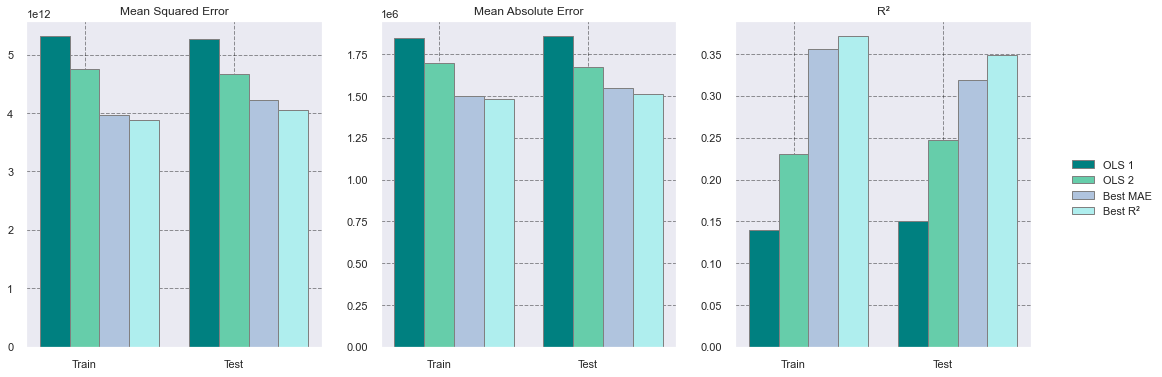

In [66]:

fig, axs = plt.subplots(1, 3, figsize=(18, 6))
width = .2
for i in range(3):
    labs = ["OLS 1", "OLS 2", "Best MAE", "Best R²"] if i == 0 else ["" for _ in range(1, 4)]
    axs[i].bar(0, ols1_results["train"][i], width, label=labs[0], color="teal", edgecolor='grey')
    axs[i].bar(0 + width, ols2_results["train"][i], width, label=labs[1], color="mediumaquamarine", edgecolor='grey')
    axs[i].bar(0 + 2 * width, ols_best_results["train"][i], width, label=labs[2], color="lightsteelblue", edgecolor='grey')
    axs[i].bar(0 + 3 * width, ols_best_results2["train"][i], width, label=labs[-1], color="paleturquoise", edgecolor='grey')
    axs[i].bar(1, ols1_results["test"][i], width, color="teal", edgecolor='grey')
    axs[i].bar(1 + width, ols2_results["test"][i], width, color="mediumaquamarine", edgecolor='grey')
    axs[i].bar(1 + 2 * width, ols_best_results["test"][i], width, color="lightsteelblue", edgecolor='grey')
    axs[i].bar(1 + 3 * width, ols_best_results2["test"][i], width, color="paleturquoise", edgecolor='grey')

axs[0].set_title("Mean Squared Error")
axs[1].set_title("Mean Absolute Error")
axs[2].set_title("R²")

for ax in axs:
    ax.set_xticks([width, width + 1], ["Train", "Test"])
fig.legend(loc='center right')

sns.set(style="darkgrid")
axs[0].grid(color="black", which = "major", linestyle = "--", linewidth = 1, alpha = 0.4)
axs[1].grid(color="black", which = "major", linestyle = "--", linewidth = 1, alpha = 0.4)
axs[2].grid(color="black", which = "major", linestyle = "--", linewidth = 1, alpha = 0.4)



In [67]:
X_Area, y_Area = df[['Area_dummy_2']], df['Price']


In [68]:
Xtrain_area, Xtest_area, ytrain_area, ytest_area = train_test_split(
    X_Area, y_Area, test_size=0.3, random_state=72)

In [69]:
Area_reg = LinearRegression()

In [70]:
Area_reg.fit(Xtrain_area, ytrain_area)

LinearRegression()

In [71]:
y_Area_pred = Area_reg.predict(Xtrain_area)

In [72]:
# 2 degrees of polynomials, without the constant
poly2 = PolynomialFeatures(2, include_bias=False) 
# Define a new X with the squared feature
Xtrain_area2 = poly2.fit_transform(Xtrain_area)
Xtest_area2 = poly2.fit_transform(Xtest_area)

Xtrain_area2[:5, :] # Check the first five rows of our new features

array([[ 30., 900.],
       [ 18., 324.],
       [ 30., 900.],
       [ 30., 900.],
       [ 30., 900.]])

In [73]:
Area_reg2 = LinearRegression()

In [74]:
# Fit the estimator 
Area_reg2.fit(Xtrain_area2, ytrain_area)
# Add the predictions to our `crops` dataframe
y_Area_pred2 = Area_reg2.predict(Xtrain_area2)

InvalidIndexError: (slice(None, None, None), None)

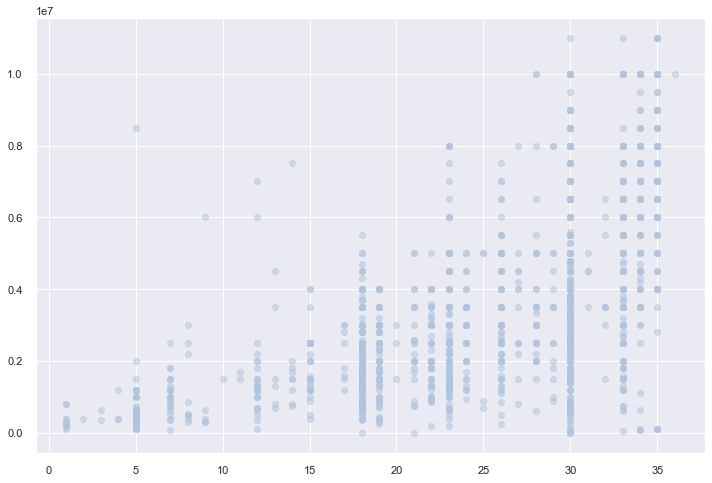

In [75]:
# Visualize our predictions
# Set up the canvas
fig, ax = plt.subplots(figsize=(12, 8))
# Add scatterplot
ax.scatter(Xtrain_area, ytrain_area, label="Data", alpha=0.5, color='lightsteelblue')
ax.plot(Xtrain_area, y_Area_pred, "-o", label="Prediction (1)", color="green")
ax.scatter(Xtrain_area, y_Area_pred2, label="Prediction (2)", color='blue')#, "-o", label="Prediction (2)", color="green")

# Label axes
ax.set_xlabel("\nDistances of Area From Center")
ax.set_ylabel("Price")
# Add a grid
ax.grid(True)
# Add a legend
ax.legend()

sns.set(style="darkgrid")
ax.grid(color="black", which = "major", linestyle = "--", linewidth = 1, alpha = 0.4)

area_list = []
for y in df.Area.unique():
    area_list.append(y)
    
xticklabels = area_list
plt.xticks(xticks, xticklabels, rotation=90)

ylabels = ['{:,.1f}'.format(y) + 'mm' for y in ax.get_yticks()/1000000]
ax.set_yticklabels(ylabels)

In [76]:
Area_score2 = Area_reg2.score(Xtrain_area2, ytrain_area)
Area_score = Area_reg.score(Xtrain_area, ytrain_area)


# Compute the MAE of our new model
Area_score_mae = np.mean(np.abs(y_Area_pred - ytrain_area))
Area_score_mae2 = np.mean(np.abs(y_Area_pred2 - ytrain_area))
mean_of_price_area = ytrain_area.mean()

In [77]:
print(f'for the first regression without the city lekki we have a R2 score of {Area_score:.2f}\n'
     f'for the second regression without the city lekki we have a R2 score of {Area_score2:.2f}\n'
     f'for the first regression without the city lekki we have a mae of {Area_score_mae:.2f}\n'
     f'for the second regression without the city lekki we have a mae of {Area_score_mae2:.2f}\n\n'
     f'-> In comparison, the price column has a mean of {mean_of_price_area:.2f}')

for the first regression without the city lekki we have a R2 score of 0.32
for the second regression without the city lekki we have a R2 score of 0.36
for the first regression without the city lekki we have a mae of 1386191.58
for the second regression without the city lekki we have a mae of 1342287.64

-> In comparison, the price column has a mean of 3830192.10


In [ ]:
# Split the dataset into train and test sets
#Xtrain_area, Xtest_area, ytrain_area, ytest_area = train_test_split(
#    X_Area, y_Area, test_size=0.3, random_state=72)

In [78]:


Xtrain_s_area = standardize(Xtrain_area)



Xtest_s_area = standardize(Xtest_area)


In [79]:

mae_mean_list_area = []
mae_se_list_area = []

r2_score_list_area = []



ols_cv_area = LinearRegression()

for p in range(1, 41):
    

    poly_area = PolynomialFeatures(p, include_bias=False)
    
    X_cv_area = poly_area.fit_transform(Xtrain_area)
    #X_cv_area = np.apply_along_axis(standardize,0, X_cv_area)

    mae_cv_area = -cross_val_score(ols_cv_area, X_cv_area, ytrain_area, cv=20, scoring="neg_mean_absolute_error")
    
    mae_mean_list_area.append(np.mean(mae_cv_area)) 
    mae_se_list_area.append(np.std(mae_cv_area) / np.sqrt(20))
        
    r2_score_area = cross_val_score(ols_cv_area, X_cv_area, ytrain_area, cv=20, scoring="r2")

    r2_score_list_area.append(np.mean(r2_score_area))


C:\Users\laure\AppData\Local\Temp\ipykernel_22400\22181168.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(ylabels)


[Text(0, 1225000.0, '1.2mm'),
 Text(0, 1250000.0, '1.2mm'),
 Text(0, 1275000.0, '1.3mm'),
 Text(0, 1300000.0, '1.3mm'),
 Text(0, 1325000.0, '1.3mm'),
 Text(0, 1350000.0, '1.4mm'),
 Text(0, 1375000.0, '1.4mm'),
 Text(0, 1400000.0, '1.4mm'),
 Text(0, 1425000.0, '1.4mm')]

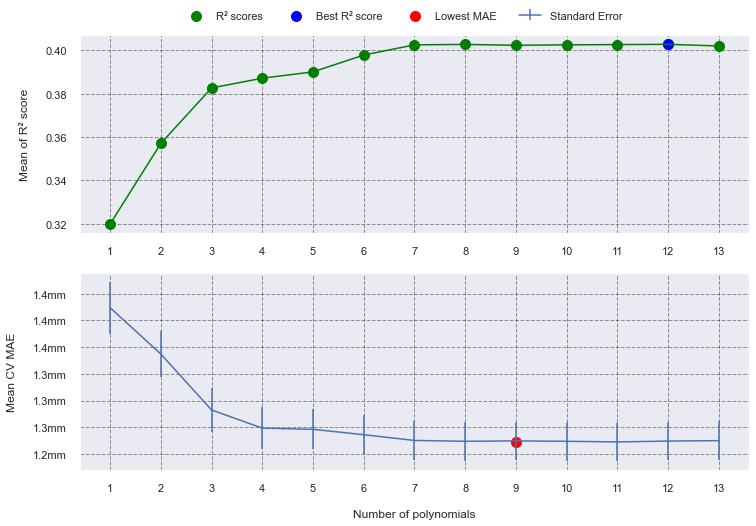

In [80]:

fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=False, sharey=False)

best_r2_area = np.argmax(r2_score_list_area[0:41])

ax[0].scatter([i for i in range(1, 14)], r2_score_list_area[0:13], color="green", s=100, label="R² scores")
ax[0].plot([i for i in range(1, 14)], r2_score_list_area[0:13], color="green")
ax[0].scatter(best_r2_area+1, r2_score_list_area[best_r2_area], color="blue", s=100, label="Best R² score")




ax[0].set_ylabel("Mean of R² score\n")

ax[0].set_xticks(range(1, 14), range(1, 14))

ax[1].errorbar(range(1, 14), mae_mean_list_area[0:13], yerr=mae_se_list_area[0:13], label='Standard Error')
best_area = np.argmin(mae_mean_list_area)
ax[1].scatter(best+1, mae_mean_list_area[best_area], color="red", s=100, label="Lowest MAE")

ax[1].set_xlabel("\nNumber of polynomials")
ax[1].set_ylabel("Mean CV MAE\n")

ax[1].grid(True)
ax[1].set_xticks(range(1, 14), range(1, 14))

fig.legend(ncol=4, loc='upper center', bbox_to_anchor=(0.5, 0.94))

sns.set(style="darkgrid")
ax[0].grid(color="black", which = "major", linestyle = "--", linewidth = 1, alpha = 0.4)
ax[1].grid(color="black", which = "major", linestyle = "--", linewidth = 1, alpha = 0.4)


ylabels = ['{:,.1f}'.format(y) + 'mm' for y in ax[1].get_yticks()/1000000]
ax[1].set_yticklabels(ylabels)

C:\Users\laure\AppData\Local\Temp\ipykernel_22400\1068343136.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(ylabels)


[Text(0, 1200000.0, '1.2mm'),
 Text(0, 1250000.0, '1.2mm'),
 Text(0, 1300000.0, '1.3mm'),
 Text(0, 1350000.0, '1.4mm'),
 Text(0, 1400000.0, '1.4mm'),
 Text(0, 1450000.0, '1.4mm'),
 Text(0, 1500000.0, '1.5mm'),
 Text(0, 1550000.0, '1.6mm'),
 Text(0, 1600000.0, '1.6mm')]

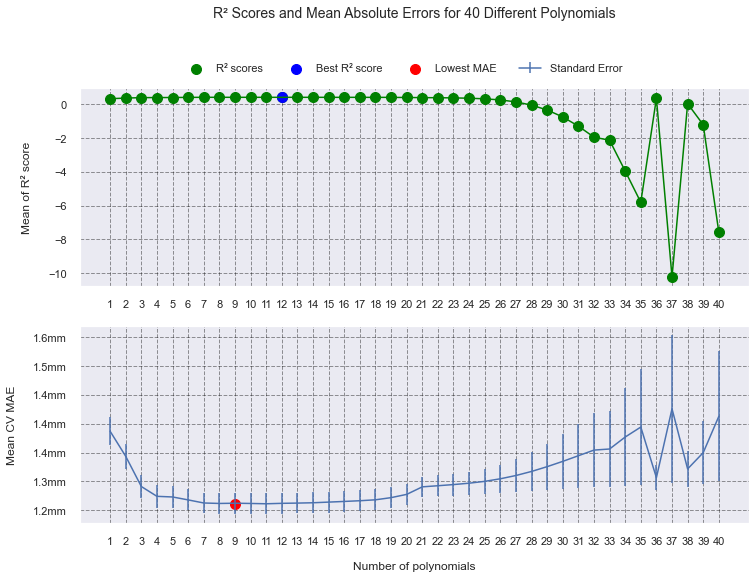

In [82]:

fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=False, sharey=False)

best_r2_area = np.argmax(r2_score_list_area[0:41])

ax[0].scatter([i for i in range(1, 41)], r2_score_list_area[0:41], color="green", s=100, label="R² scores")
ax[0].plot([i for i in range(1, 41)], r2_score_list_area[0:41], color="green")
ax[0].scatter(best_r2_area+1, r2_score_list_area[best_r2_area], color="blue", s=100, label="Best R² score")




ax[0].set_ylabel("Mean of R² score\n")

ax[0].set_xticks(range(1, 41), range(1, 41))

ax[1].errorbar(range(1, 41), mae_mean_list_area, yerr=mae_se_list_area, label='Standard Error')
best_area = np.argmin(mae_mean_list_area)
ax[1].scatter(best+1, mae_mean_list_area[best_area], color="red", s=100, label="Lowest MAE")

ax[1].set_xlabel("\nNumber of polynomials")
ax[1].set_ylabel("Mean CV MAE\n")

ax[1].grid(True)
ax[1].set_xticks(range(1, 41), range(1, 41))

fig.legend(ncol=4, loc='upper center', bbox_to_anchor=(0.5, 0.94))

sns.set(style="darkgrid")
ax[0].grid(color="black", which = "major", linestyle = "--", linewidth = 1, alpha = 0.4)
ax[1].grid(color="black", which = "major", linestyle = "--", linewidth = 1, alpha = 0.4)

ax[0].set_title('R² Scores and Mean Absolute Errors for 40 Different Polynomials\n\n\n\n', size=14)
ylabels = ['{:,.1f}'.format(y) + 'mm' for y in ax[1].get_yticks()/1000000]
ax[1].set_yticklabels(ylabels)

In [86]:
# Define model
ols_best_area = LinearRegression()
# Compute polynomials
poly_best_area = PolynomialFeatures(9, include_bias=False)

Xtrain_best_area = poly_best_area.fit_transform(Xtrain_s_area)
Xtrain_best_area = np.apply_along_axis(standardize,0, Xtrain_best_area)

Xtest_best_area = poly_best_area.fit_transform(Xtest_s_area)
Xtest_best_area = np.apply_along_axis(standardize,0, Xtest_best_area)

# Fit model
ols_best_area.fit(Xtrain_best_area, ytrain_area)
# OLS with 9 features
ols_best_results_area = {
    "train": [f(ols_best_area, Xtrain_best_area, ytrain_area) for f in [compute_mse, compute_mae, compute_r2]],
    "test": [f(ols_best_area, Xtest_best_area, ytest_area) for f in [compute_mse, compute_mae, compute_r2]]
}

print("ols_best_results_area: train: ", ols_best_results["train"])
print("\nols_best_results: test: ", ols_best_results["test"])




ols_best_results_area: train:  [3973577899361.879, 1503353.0551408464, 0.356283528519032]

ols_best_results: test:  [4224904178894.554, 1545675.5428179295, 0.31918761762064674]


In [87]:
# Define model
ols_best_area2 = LinearRegression()
# Compute polynomials
poly_best_area2 = PolynomialFeatures(12, include_bias=False)

Xtrain_best_area2 = poly_best_area2.fit_transform(Xtrain_s_area)
Xtrain_best_area2 = np.apply_along_axis(standardize,0, Xtrain_best_area2)

Xtest_best_area2 = poly_best_area2.fit_transform(Xtest_s_area)
Xtest_best_area2 = np.apply_along_axis(standardize,0, Xtest_best_area2)

# Fit model
ols_best_area2.fit(Xtrain_best_area2, ytrain_area)
# OLS with 9 features
ols_best_results_area2 = {
    "train": [f(ols_best_area2, Xtrain_best_area2, ytrain_area) for f in [compute_mse, compute_mae, compute_r2]],
    "test": [f(ols_best_area2, Xtest_best_area2, ytest_area) for f in [compute_mse, compute_mae, compute_r2]]
}

print("ols_best_results: train: ", ols_best_results_area2["train"])
print("\nols_best_results: test: ", ols_best_results_area2["test"])





ols_best_results: train:  [2856390024274.3857, 1258488.8924421023, 0.4133056243528781]

ols_best_results: test:  [2753124098808.784, 1226008.5623564539, 0.3998233903263346]


In [89]:
# Compute the metrics into lists for plotting
# OLS with single feature
ols1_results_area = {
    "train": [f(Area_reg, Xtrain_area, ytrain_area) for f in [compute_mse, compute_mae, compute_r2]],
    "test": [f(Area_reg, Xtest_area, ytest_area) for f in [compute_mse, compute_mae, compute_r2]]
}
# OLS with 2 features
ols2_results_area = {
    "train": [f(Area_reg2, Xtrain_area2, ytrain_area) for f in [compute_mse, compute_mae, compute_r2]],
    "test": [f(Area_reg2, Xtest_area2, ytest_area) for f in [compute_mse, compute_mae, compute_r2]]
}
# OLS with multiple features


# OK, this list comprehensions may feel a little dense, but you see that they are very elegant and practical. Do you understand them?
# Here is their output:

print("ols1: ", ols1_results_area)
print("\nols2: ", ols2_results_area)



ols1:  {'train': [3294307454874.175, 1386191.5844575278, 0.3233586313486613], 'test': [3058215459788.172, 1331057.7210322954, 0.33331396608622954]}

ols2:  {'train': [3099379454015.211, 1342287.6378897196, 0.36339628754693487], 'test': [2910221255020.026, 1294109.5027403363, 0.3655764638456007]}


C:\Users\laure\AppData\Local\Temp\ipykernel_22400\4260752600.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_yticklabels(ylabels1)
C:\Users\laure\AppData\Local\Temp\ipykernel_22400\4260752600.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_yticklabels(ylabels2)


[Text(0, 0.0, '0.0mm'),
 Text(0, 200000.0, '0.2mm'),
 Text(0, 400000.0, '0.4mm'),
 Text(0, 600000.0, '0.6mm'),
 Text(0, 800000.0, '0.8mm'),
 Text(0, 1000000.0, '1.0mm'),
 Text(0, 1200000.0, '1.2mm'),
 Text(0, 1400000.0, '1.4mm'),
 Text(0, 1600000.0, '1.6mm')]

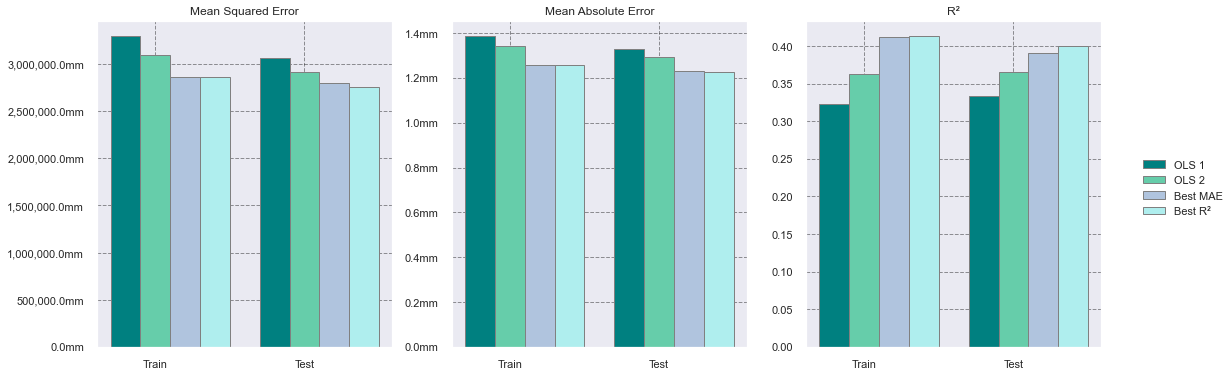

In [90]:
# Plot the metrics (🙀 🤯 same code as above, no need to focus on it for now)
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
width = .2 # Bar width
for i in range(3):
    labs = ["OLS 1", "OLS 2", "Best MAE", "Best R²"] if i == 0 else ["" for _ in range(1, 4)]
    axs[i].bar(0, ols1_results_area["train"][i], width, label=labs[0], color="teal", edgecolor='grey')
    axs[i].bar(0 + width, ols2_results_area["train"][i], width, label=labs[1], color="mediumaquamarine", edgecolor='grey')
    axs[i].bar(0 + 2 * width, ols_best_results_area["train"][i], width, label=labs[2], color="lightsteelblue", edgecolor='grey')
    axs[i].bar(0 + 3 * width, ols_best_results_area2["train"][i], width, label=labs[-1], color="paleturquoise", edgecolor='grey')
    axs[i].bar(1, ols1_results_area["test"][i], width, color="teal", edgecolor='grey')
    axs[i].bar(1 + width, ols2_results_area["test"][i], width, color="mediumaquamarine", edgecolor='grey')
    axs[i].bar(1 + 2 * width, ols_best_results_area["test"][i], width, color="lightsteelblue", edgecolor='grey')
    axs[i].bar(1 + 3 * width, ols_best_results_area2["test"][i], width, color="paleturquoise", edgecolor='grey')
    
# Plot titles
axs[0].set_title("Mean Squared Error")
axs[1].set_title("Mean Absolute Error")
axs[2].set_title("R²")
# Labels and legend
for ax in axs:
    ax.set_xticks([width, width + 1], ["Train", "Test"])
fig.legend(loc='center right')

sns.set(style="darkgrid")
axs[0].grid(color="black", which = "major", linestyle = "--", linewidth = 1, alpha = 0.4)
axs[1].grid(color="black", which = "major", linestyle = "--", linewidth = 1, alpha = 0.4)
axs[2].grid(color="black", which = "major", linestyle = "--", linewidth = 1, alpha = 0.4)


ylabels1 = ['{:,.1f}'.format(y) + 'mm' for y in axs[0].get_yticks()/1000000]
axs[0].set_yticklabels(ylabels1)

ylabels2 = ['{:,.1f}'.format(y) + 'mm' for y in axs[1].get_yticks()/1000000]
axs[1].set_yticklabels(ylabels2)

#plt.title('Area Metrics\n')

In [91]:
y_Area_pred3 = ols_best_area.predict(Xtrain_best_area)

InvalidIndexError: (slice(None, None, None), None)

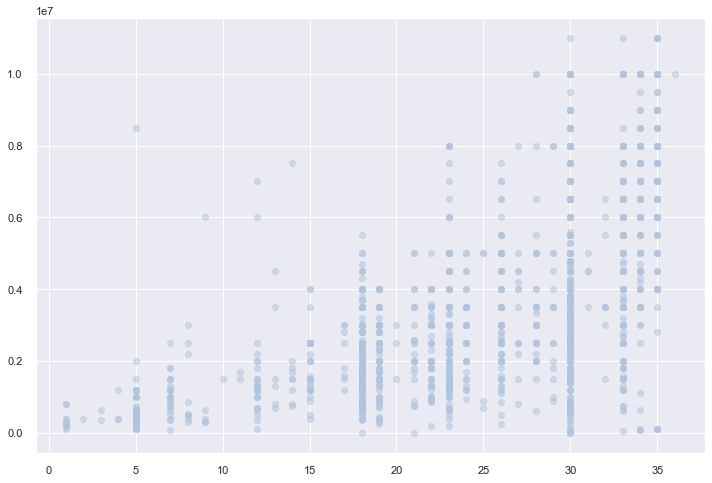

In [93]:
# Visualize our predictions
# Set up the canvas
fig, ax = plt.subplots(figsize=(12, 8))
# Add scatterplot
ax.scatter(Xtrain_area, ytrain_area, label="Data", alpha=0.5, color='lightsteelblue')
ax.plot(Xtrain_area, y_Area_pred, "-o", label="Prediction (1)", color="green")
ax.scatter(Xtrain_area, y_Area_pred2, label="Prediction (2)", color="blue")#, "-o", label="Prediction (2)", color="green")
ax.scatter(Xtrain_area, y_Area_pred3, label="Prediction (3)", color="red")#, "-o", label="Prediction (2)", color="green")

# Label axes
ax.set_xlabel("\n Area")
ax.set_ylabel("Price")
# Add a grid
ax.grid(True)
# Add a legend
ax.legend(facecolor='grey')
ax.set_title('Univariate Regression With Area as Feature\n', size=14)

sns.set(style="darkgrid")
ax.grid(color="black", which = "major", linestyle = "--", linewidth = 1, alpha = 0.4)


ylabels = ['{:,.1f}'.format(y) + 'mm' for y in ax.get_yticks()/1000000]
ax.set_yticklabels(ylabels)

area_list = []
for y in df.Area.unique():
    area_list.append(y)
    
xticklabels = area_list
plt.xticks(xticks, xticklabels, rotation=90)

C:\Users\laure\AppData\Local\Temp\ipykernel_22400\1895046902.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(xlabels)
C:\Users\laure\AppData\Local\Temp\ipykernel_22400\1895046902.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels(ylabels)
C:\Users\laure\AppData\Local\Temp\ipykernel_22400\1895046902.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(xlabels)
C:\Users\laure\AppData\Local\Temp\ipykernel_22400\1895046902.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(ylabels)


[]

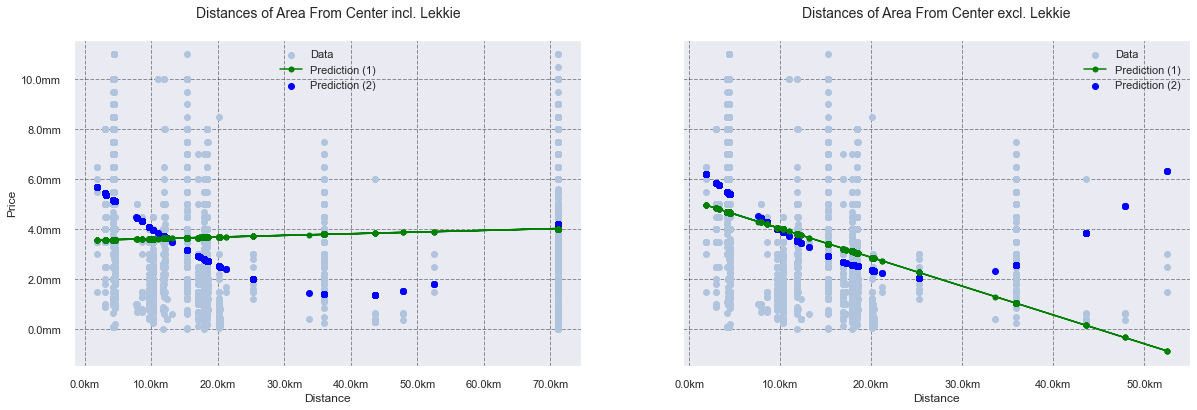

In [94]:
# Visualize our predictions
# Set up the canvas
fig, ax = plt.subplots(1,2, figsize=(20, 6), sharey=True)
# Add scatterplot
ax[0].scatter(df_reg["distances_of_area_from_center"], df_reg["Price"], label="Data", color='lightsteelblue')
ax[0].plot(df_reg["distances_of_area_from_center"], df_reg["pred"], "-o", label="Prediction (1)", color="green")
ax[0].scatter(df_reg["distances_of_area_from_center"], df_reg["pred2"], color="blue", label="Prediction (2)")#, "-o", label="Prediction (2))"
# Label axes
ax[0].set_xlabel("Distance")
ax[0].set_ylabel("Price")
# Add a grid
ax[0].grid(True)
# Add a legend
ax[0].legend(facecolor="gray")
ax[0].set_title('Distances of Area From Center incl. Lekkie\n', size=14)

sns.set(style="darkgrid")
ax[0].grid(color="black", which = "major", linestyle = "--", linewidth = 1, alpha = 0.4)

xlabels = ['{:,.1f}'.format(x) + 'km' for x in ax[0].get_xticks()]
ax[0].set_xticklabels(xlabels)

ylabels = ['{:,.1f}'.format(y) + 'mm' for y in ax[0].get_yticks()/1000000]
ax[0].set_yticklabels(ylabels)

# Visualize our predictions
# Set up the canvas

# Add scatterplot
ax[1].scatter(df_no_lekki["distances_of_area_from_center"], df_no_lekki["Price"], label="Data", color='lightsteelblue')
ax[1].plot(df_no_lekki["distances_of_area_from_center"], df_no_lekki["pred"], "-o", label="Prediction (1)", color="green")
ax[1].scatter(df_no_lekki["distances_of_area_from_center"], df_no_lekki["pred2"], label="Prediction (2)", color="blue")#, "-o", label="Prediction (2)")
# Label axes
ax[1].set_xlabel("Distance")
#ax[1].set_ylabel("Price")
# Add a grid
ax[1].grid(True)
# Add a legend
ax[1].legend(facecolor="grey")
ax[1].set_title('Distances of Area From Center excl. Lekkie\n', size=14)

sns.set(style="darkgrid")
ax[1].grid(color="black", which = "major", linestyle = "--", linewidth = 1, alpha = 0.4)


xlabels = ['{:,.1f}'.format(x) + 'km' for x in ax[1].get_xticks()]
ax[1].set_xticklabels(xlabels)

ylabels = ['{:,.1f}'.format(y) + 'mm' for y in ax[1].get_yticks()/1000000]
ax[1].set_yticklabels(ylabels)


